In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import string
from tqdm.notebook import tqdm

from collections import Counter

In [2]:
# I retrieve the dataframe created in Wordle Setup notebook:

all_words = pd.read_pickle('../data/words.pkl')
all_words['guesses'] = 0
all_words['times_guessed'] = 0

In [3]:
letters = [letter for letter in string.ascii_lowercase]
positions = [f'{position}{letter}' for letter in letters for position in range(1, 6)]

In [4]:
# The "guess_word" function takes the current state of the word DataFrame, and returns the best possible guess.
# This function can be modified if the metric for evaluation changes.

def guess_word(words):
    best_words = words['score'].sort_values(ascending=False)
    best_guess = best_words.index[0]
            
    return best_guess

In [5]:
# The "evaluate_guess" function takes the guessed word, and returns the evaluation for each letter.
# The function makes three passes through the letters in the guessed word.
#
# On the first pass, "green" letters are found.
# "Green" letters are letters in the guessed word that are in the solution word and also in the same position.
#
# On the second pass, "yellow" and "black" letters are found.
# "Yellow" letters are letters in the guessed word that are in the solution word but not in the same position.
# "Black" letters are letters in the guessed word that are not in the solution word.
# 
# The evaluations ("green", "yellow", or "black") determine which words can be eliminated as potential solutions.
# During the second and third passes, the function eliminates invalid words from the solution set.


def evaluate_guess(guess, solution, words, guessed_p):    
    result = ['?', '?', '?', '?', '?']

    guess_counts = Counter(guess)
    solution_counts = Counter(solution)
    
    green_counts = Counter()
    yellow_counts = Counter()

    # First pass
    for pos in range(5):
        letter = guess[pos]
        index = (ord(letter) - ord('a')) * 5 + pos
        guessed_p[index] = 0
        
        if solution[pos] == letter:
            result[pos] = 'g'
            green_counts[letter] += 1
            
    # Second pass
    for pos in range(5):
        letter = guess[pos]
        position = f'{pos+1}{letter}'

        if result[pos] == 'g':
            words['is_valid'] *= words[position].values.astype(bool)

        elif solution_counts[letter] - (green_counts[letter] + yellow_counts[letter]) > 0:
            result[pos] = 'y'
            words['is_valid'] *= ~words[position].values.astype(bool)
            yellow_counts[letter] += 1
            
        else:
            result[pos] = 'b'
            if green_counts[letter] > 0:
                for i in range(pos, 5):
                    if not (guess[i] == letter and result[i] == 'g'):
                        words['is_valid'] *= ~words[f'{i+1}{letter}'].values.astype(bool)
            elif yellow_counts[letter] > 0:
                words['is_valid'] *= ~words[position].values.astype(bool)
            else:
                words['is_valid'] *= ~words[letter].astype(bool)
                
    # Final pass
    for letter in set(guess):
        if (letter_count := (green_counts[letter] + yellow_counts[letter])) > 0:
            words['is_valid'] *= (words[letter].values >= letter_count)
        
    return ''.join(result)

In [6]:
# The "adjust_score" function recalculates the "letter score" and "position score" for each word.
# The process for calculating these scores is identical to the process in the Wordle Setup notebook.

def adjust_score(words, words_l, words_p, guessed_p):
    valid_words = words[words['is_valid']]
    
    valid_positions = valid_words[positions].values

    position_scores = np.sum(valid_positions * guessed_p, axis=0) / len(valid_words) * 100
    
    letter_scores = position_scores.reshape((-1, 5)).sum(axis=1)
    
    words['letter_score'] = np.sum(letter_scores * words_l, axis=1)
        
    words['position_score'] = np.sum(position_scores * words_p, axis=1)
    
    words['score'] = words['letter_score'] + words['position_score']

In [7]:
# The "solve_word" function takes a word and records the number of guesses it takes to solve for that word.
# If the solution word is not guessed within six attempts, it returns a penalty of 100 guesses.
#
# If there is only one valid word remaining, the function returns the current guess number.
#
# If there are only two valid words, the function guesses the first of the two words.
# Without this optimization, the algorithm will always guess an invalid word to eliminate one of the valid words.


def solve_word(all_words, solution):
    words = all_words.copy()

    words_l = words[letters].astype(bool).values
    words_p = words[positions].values

    guessed_p = np.ones((len(positions),), dtype=int)
    
    for guess_num in range(1, 7):
        valid_words = words[words['is_valid']]
        if len(valid_words) == 1:
            all_words.loc[solution, 'guesses'] = guess_num
            return
        elif len(valid_words) == 2:
            guess = valid_words.index[0]
        else:
            guess = guess_word(words)
            
        result = evaluate_guess(guess, solution, words, guessed_p)
        
        if result == 'ggggg':
            all_words.loc[solution, 'guesses'] = guess_num
            return
        
        all_words.loc[guess, 'times_guessed'] += 1
        
        adjust_score(words, words_l, words_p, guessed_p)
            
    # Penalty for failure to solve within 6 guesses.
    print(solution)
    all_words.loc[solution, 'guesses'] = 100

In [8]:
# When I first solved for all 2315 words, the function solved six words every second on my machine.
# After optimizing for performance, the function solves 25 words every second on my machine.

for valid_word in tqdm(all_words[all_words['is_valid']].index):
    solve_word(all_words, valid_word)

  0%|          | 0/2315 [00:00<?, ?it/s]

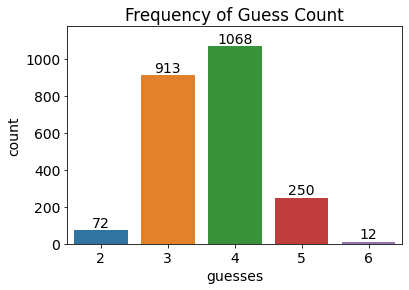

In [9]:
# I make a count plot to visualize how well the algorithm performs:

valid_words = all_words[all_words['is_valid']]

plt.rcParams.update({'font.size': 14})
ax = sns.countplot(x=valid_words.guesses)
_ = ax.bar_label(ax.containers[0])
_ = ax.margins(y=0.1)
_ = plt.title("Frequency of Guess Count")
_ = plt.savefig('../results.png', facecolor='white', bbox_inches='tight')

# Most words are solved in four guesses or fewer.
# Every word is solved within the required six-guess limit.
# These are the words that take six guesses to solve:
# maker, waver, rarer, riper, revel, taunt, hatch, wedge, vouch, hitch, tight, daddy

In [10]:
# The mean guess count:

round(np.mean(valid_words.guesses), 2)

3.66

In [11]:
# The total number of guesses for all words:

np.sum(valid_words.guesses)

# This is the number that I would use to compare my algorithm with others.
# There are many ways that I could improve my algorithm from here.
# I could adjust the ratio between the "position score" and the "letter score."
# I could also try different words for the first guess.

8477

In [12]:
# A list of words guessed by the algorithm, not counting solution words:

words_guessed = all_words.query('times_guessed > 0')[['is_valid', 'times_guessed', 'score']]
words_guessed.sort_values('times_guessed', ascending=False)

# Only ~700 words are guessed out of the ~13,000 words in the word bank.

,is_valid,times_guessed,score
soare,False,2315,261.857451
linty,False,183,174.989201
canty,False,138,186.997840
inlet,True,119,204.362851
cider,True,116,202.073434
...,...,...,...
topic,True,1,158.660907
ultra,True,1,188.077754
lodge,True,1,187.991361
ensue,True,1,159.352052


<AxesSubplot:xlabel='score', ylabel='times_guessed'>

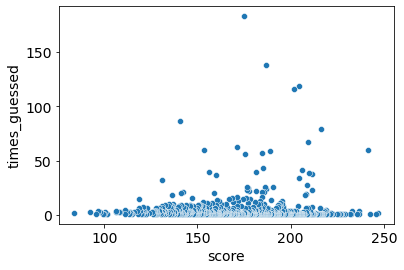

In [13]:
sns.scatterplot(x=words_guessed.iloc[1:].score, y=words_guessed.iloc[1:].times_guessed)

In [14]:
words_guessed.is_valid.value_counts()

True     519
False    183
Name: is_valid, dtype: int64